In [1]:
#importing libraries
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

import os
import re
import nltk
import nltk
nltk.download('punkt')
import requests
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
nltk.download("stopwords")

from PIL import Image
warnings.filterwarnings('ignore')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\atrit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\atrit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# putting together the GoodRead datsets into one full dataset
from pathlib import Path
full_dataset = pd.concat([pd.read_csv(str(x.resolve())) for x in Path("GoodReads_data").glob("*k.csv")])
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1850310 entries, 0 to 40889
Data columns (total 21 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Id                     int64  
 1   Name                   object 
 2   RatingDist1            object 
 3   pagesNumber            float64
 4   RatingDist4            object 
 5   RatingDistTotal        object 
 6   PublishMonth           int64  
 7   PublishDay             int64  
 8   Publisher              object 
 9   CountsOfReview         int64  
 10  PublishYear            int64  
 11  Language               object 
 12  Authors                object 
 13  Rating                 float64
 14  RatingDist2            object 
 15  RatingDist5            object 
 16  ISBN                   object 
 17  RatingDist3            object 
 18  Description            object 
 19  Count of text reviews  float64
 20  PagesNumber            float64
dtypes: float64(4), int64(5), object(12)
memory usage: 310.6+

In [3]:
full_dataset.head(5)

,Id,Name,RatingDist1,pagesNumber,RatingDist4,RatingDistTotal,PublishMonth,PublishDay,Publisher,CountsOfReview,...,Language,Authors,Rating,RatingDist2,RatingDist5,ISBN,RatingDist3,Description,Count of text reviews,PagesNumber
0,1,Harry Potter and the Half-Blood Prince (Harry ...,1:9896,652.0,4:556485,total:2298124,16,9,Scholastic Inc.,28062,...,eng,J.K. Rowling,4.57,2:25317,5:1546466,NaN,3:159960,NaN,NaN,NaN
1,2,Harry Potter and the Order of the Phoenix (Har...,1:12455,870.0,4:604283,total:2358637,1,9,Scholastic Inc.,29770,...,eng,J.K. Rowling,4.50,2:37005,5:1493113,0439358078,3:211781,NaN,NaN,NaN
2,3,Harry Potter and the Sorcerer's Stone (Harry P...,1:108202,309.0,4:1513191,total:6587388,1,11,Scholastic Inc,75911,...,eng,J.K. Rowling,4.47,2:130310,5:4268227,NaN,3:567458,NaN,NaN,NaN
3,4,Harry Potter and the Chamber of Secrets (Harry...,1:11896,352.0,4:706082,total:2560657,1,11,Scholastic,244,...,eng,J.K. Rowling,4.42,2:49353,5:1504505,0439554896,3:288821,NaN,NaN,NaN
4,5,Harry Potter and the Prisoner of Azkaban (Harr...,1:10128,435.0,4:630534,total:2610317,1,5,Scholastic Inc.,37093,...,eng,J.K. Rowling,4.57,2:24849,5:1749958,043965548X,3:194848,NaN,NaN,NaN


In [4]:
#removing unneeded columns
full_dataset.drop(columns=["RatingDist1", "pagesNumber", "RatingDist4", "RatingDistTotal", "PublishMonth", "PublishDay", "RatingDist2", "RatingDist5", "RatingDist3", "Description", "Count of text reviews", "PagesNumber"], inplace=True)

full_dataset.head(5)

,Id,Name,Publisher,CountsOfReview,PublishYear,Language,Authors,Rating,ISBN
0,1,Harry Potter and the Half-Blood Prince (Harry ...,Scholastic Inc.,28062,2006,eng,J.K. Rowling,4.57,NaN
1,2,Harry Potter and the Order of the Phoenix (Har...,Scholastic Inc.,29770,2004,eng,J.K. Rowling,4.50,0439358078
2,3,Harry Potter and the Sorcerer's Stone (Harry P...,Scholastic Inc,75911,2003,eng,J.K. Rowling,4.47,NaN
3,4,Harry Potter and the Chamber of Secrets (Harry...,Scholastic,244,2003,eng,J.K. Rowling,4.42,0439554896
4,5,Harry Potter and the Prisoner of Azkaban (Harr...,Scholastic Inc.,37093,2004,eng,J.K. Rowling,4.57,043965548X


In [5]:
#fix the unrealistic years
full_dataset[(full_dataset['PublishYear'] < 1400) | (full_dataset['PublishYear'] > 2020)]
full_dataset = full_dataset[full_dataset['PublishYear'] > 1400]
full_dataset = full_dataset[full_dataset['PublishYear'] < 2022]
full_dataset.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1850262 entries, 0 to 40889
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   Id              1850262 non-null  int64  
 1   Name            1850262 non-null  object 
 2   Publisher       1832442 non-null  object 
 3   CountsOfReview  1850262 non-null  int64  
 4   PublishYear     1850262 non-null  int64  
 5   Language        251797 non-null   object 
 6   Authors         1850262 non-null  object 
 7   Rating          1850262 non-null  float64
 8   ISBN            1844343 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 141.2+ MB


In [6]:
#language english only

#first check
#print(full_dataset.Language.unique())
#full_dataset["Language"].describe()

#change english subtypes to just english
full_dataset["Language"].replace(["en-GB", "en-CA", "en-US"], "eng", inplace=True)
print(full_dataset.Language.unique())
full_dataset["Language"].describe()

#excluding all but english
full_dataset = full_dataset[full_dataset["Language"] == "eng"]
full_dataset.info(show_counts=True)

['eng' nan 'fre' 'spa' 'mul' 'grc' 'enm' 'ger' 'jpn' 'ara' 'nl' 'zho'
 'lat' 'por' 'srp' 'ita' 'rus' 'msa' 'glg' 'wel' 'swe' 'nor' 'kor' 'tur'
 'gla' 'lit' 'per' 'pol' 'gle' 'cat' 'afr' 'ind' 'frs' 'sco' 'cze' 'rum'
 'raj' 'ang' 'eus' 'ypk' 'frm' 'nav' 'myn' 'gre' 'urd' 'elx' 'guj' 'epo'
 'dan' 'nqo' 'cop' 'tel' 'gem' 'hun' 'haw' 'tib' 'heb' 'sam' 'bul' 'tlh'
 'tah' 'slv' 'hin' 'slo' 'mar' 'mah' 'fro' 'aze' 'kan' 'non' 'tli' 'san'
 'scr' 'fin' 'isl' 'mal' 'bos' 'hmn' 'tgl' 'cre' 'gmh' 'ave' 'mga' '--'
 'lav' 'yid' 'nld' 'hye' 'est' 'tha' 'sqi' 'ben' 'ada' 'zap' 'aus' 'kur'
 'nob' 'nep' 'nai' 'nub' 'chi' 'som' 'rar' 'vie' 'goh' 'jav' 'mri' 'che'
 'sna' 'myv' 'zul' 'lao' 'fil' 'ira' 'ssw' 'mis' 'zun' 'dum' 'wak' 'tam'
 'chp' 'fan']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 209661 entries, 0 to 40883
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Id              209661 non-null  int64  
 1   Name    

In [7]:
#checking for duplicate entries
full_dataset.Name.value_counts()[:20]

#dropping duplicates by same name and author (different publisher might mean the book was re-published at some point)
full_dataset.drop_duplicates(subset=["Authors", "Name"], inplace=True)
full_dataset.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187249 entries, 0 to 40883
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Id              187249 non-null  int64  
 1   Name            187249 non-null  object 
 2   Publisher       184576 non-null  object 
 3   CountsOfReview  187249 non-null  int64  
 4   PublishYear     187249 non-null  int64  
 5   Language        187249 non-null  object 
 6   Authors         187249 non-null  object 
 7   Rating          187249 non-null  float64
 8   ISBN            185616 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 14.3+ MB


In [8]:
full_dataset.head()

,Id,Name,Publisher,CountsOfReview,PublishYear,Language,Authors,Rating,ISBN
0,1,Harry Potter and the Half-Blood Prince (Harry ...,Scholastic Inc.,28062,2006,eng,J.K. Rowling,4.57,NaN
1,2,Harry Potter and the Order of the Phoenix (Har...,Scholastic Inc.,29770,2004,eng,J.K. Rowling,4.50,0439358078
2,3,Harry Potter and the Sorcerer's Stone (Harry P...,Scholastic Inc,75911,2003,eng,J.K. Rowling,4.47,NaN
3,4,Harry Potter and the Chamber of Secrets (Harry...,Scholastic,244,2003,eng,J.K. Rowling,4.42,0439554896
4,5,Harry Potter and the Prisoner of Azkaban (Harr...,Scholastic Inc.,37093,2004,eng,J.K. Rowling,4.57,043965548X


In [9]:
#opening book cover dataset
cover_books = pd.read_csv('Books_data.csv')
cover_books.head()
cover_books.info()

#removing unneeded columns
cover_books.drop(columns=["user_id", "location", "age", "rating", "img_s", "img_m", "Summary", "Language", "Category", "city", "state", "country"], inplace=True)

cover_books.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031175 entries, 0 to 1031174
Data columns (total 19 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Unnamed: 0           1031175 non-null  int64  
 1   user_id              1031175 non-null  int64  
 2   location             1031175 non-null  object 
 3   age                  1031175 non-null  float64
 4   isbn                 1031175 non-null  object 
 5   rating               1031175 non-null  int64  
 6   book_title           1031175 non-null  object 
 7   book_author          1031175 non-null  object 
 8   year_of_publication  1031175 non-null  float64
 9   publisher            1031175 non-null  object 
 10  img_s                1031175 non-null  object 
 11  img_m                1031175 non-null  object 
 12  img_l                1031175 non-null  object 
 13  Summary              1031175 non-null  object 
 14  Language             1031175 non-null  object 
 15

,Unnamed: 0,isbn,book_title,book_author,year_of_publication,publisher,img_l
0,0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...
1,1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...
2,2,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...
3,3,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...
4,4,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...


In [10]:
df1 = full_dataset.copy()
df2 = cover_books.copy()

#rename book title column name for matching
df2.rename(columns = {'book_title':'Name', 'book_author':'Authors', 'img_l':'image', 'isbn': 'ISBN'}, inplace = True)
df2.head()

#select column to match and columns to add from books cover dataset
df_2_cols_to_use = ['ISBN', 'image']

df_merged = pd.merge(df1, df2[df_2_cols_to_use], on=['ISBN'], how='left')
df_merged.head(20)
#df_merged.info()

,Id,Name,Publisher,CountsOfReview,PublishYear,Language,Authors,Rating,ISBN,image
0,1,Harry Potter and the Half-Blood Prince (Harry ...,Scholastic Inc.,28062,2006,eng,J.K. Rowling,4.57,NaN,NaN
1,2,Harry Potter and the Order of the Phoenix (Har...,Scholastic Inc.,29770,2004,eng,J.K. Rowling,4.50,0439358078,http://images.amazon.com/images/P/0439358078.0...
2,2,Harry Potter and the Order of the Phoenix (Har...,Scholastic Inc.,29770,2004,eng,J.K. Rowling,4.50,0439358078,http://images.amazon.com/images/P/0439358078.0...
3,2,Harry Potter and the Order of the Phoenix (Har...,Scholastic Inc.,29770,2004,eng,J.K. Rowling,4.50,0439358078,http://images.amazon.com/images/P/0439358078.0...
4,2,Harry Potter and the Order of the Phoenix (Har...,Scholastic Inc.,29770,2004,eng,J.K. Rowling,4.50,0439358078,http://images.amazon.com/images/P/0439358078.0...
5,2,Harry Potter and the Order of the Phoenix (Har...,Scholastic Inc.,29770,2004,eng,J.K. Rowling,4.50,0439358078,http://images.amazon.com/images/P/0439358078.0...
6,2,Harry Potter and the Order of the Phoenix (Har...,Scholastic Inc.,29770,2004,eng,J.K. Rowling,4.50,0439358078,http://images.amazon.com/images/P/0439358078.0...
7,2,Harry Potter and the Order of the Phoenix (Har...,Scholastic Inc.,29770,2004,eng,J.K. Rowling,4.50,0439358078,http://images.amazon.com/images/P/0439358078.0...
8,2,Harry Potter and the Order of the Phoenix (Har...,Scholastic Inc.,29770,2004,eng,J.K. Rowling,4.50,0439358078,http://images.amazon.com/images/P/0439358078.0...
9,2,Harry Potter and the Order of the Phoenix (Har...,Scholastic Inc.,29770,2004,eng,J.K. Rowling,4.50,0439358078,http://images.amazon.com/images/P/0439358078.0...


In [11]:
#dropping duplicates from data frame after adding image column
df = df_merged.drop_duplicates(subset = ["Authors", "Name"])

In [12]:
#check for missing values in images
(df['image'].isnull().sum())

#add placeholder for entries without image link
df['image'].fillna('https://lightning.od-cdn.com/static/img/no-cover_en_US.a8920a302274ea37cfaecb7cf318890e.jpg', inplace=True)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187249 entries, 0 to 405576
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Id              187249 non-null  int64  
 1   Name            187249 non-null  object 
 2   Publisher       184576 non-null  object 
 3   CountsOfReview  187249 non-null  int64  
 4   PublishYear     187249 non-null  int64  
 5   Language        187249 non-null  object 
 6   Authors         187249 non-null  object 
 7   Rating          187249 non-null  float64
 8   ISBN            185616 non-null  object 
 9   image           187249 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 15.7+ MB


In [14]:
df.rename(columns = {'user_id':'book_id', 'Name':'book_title', 'Authors':'book_author', 'Publisher':'publisher', 'Id':'user_id', 'image':'img_l'}, inplace = True)
df.head()

,user_id,book_title,publisher,CountsOfReview,PublishYear,Language,book_author,Rating,ISBN,img_l
0,1,Harry Potter and the Half-Blood Prince (Harry ...,Scholastic Inc.,28062,2006,eng,J.K. Rowling,4.57,NaN,https://lightning.od-cdn.com/static/img/no-cov...
1,2,Harry Potter and the Order of the Phoenix (Har...,Scholastic Inc.,29770,2004,eng,J.K. Rowling,4.50,0439358078,http://images.amazon.com/images/P/0439358078.0...
12,3,Harry Potter and the Sorcerer's Stone (Harry P...,Scholastic Inc,75911,2003,eng,J.K. Rowling,4.47,NaN,https://lightning.od-cdn.com/static/img/no-cov...
13,4,Harry Potter and the Chamber of Secrets (Harry...,Scholastic,244,2003,eng,J.K. Rowling,4.42,0439554896,http://images.amazon.com/images/P/0439554896.0...
16,5,Harry Potter and the Prisoner of Azkaban (Harr...,Scholastic Inc.,37093,2004,eng,J.K. Rowling,4.57,043965548X,http://images.amazon.com/images/P/043965548X.0...


In [15]:
#reset index
df = df.reset_index(drop=True)
df

,user_id,book_title,publisher,CountsOfReview,PublishYear,Language,book_author,Rating,ISBN,img_l
0,1,Harry Potter and the Half-Blood Prince (Harry ...,Scholastic Inc.,28062,2006,eng,J.K. Rowling,4.57,NaN,https://lightning.od-cdn.com/static/img/no-cov...
1,2,Harry Potter and the Order of the Phoenix (Har...,Scholastic Inc.,29770,2004,eng,J.K. Rowling,4.50,0439358078,http://images.amazon.com/images/P/0439358078.0...
2,3,Harry Potter and the Sorcerer's Stone (Harry P...,Scholastic Inc,75911,2003,eng,J.K. Rowling,4.47,NaN,https://lightning.od-cdn.com/static/img/no-cov...
3,4,Harry Potter and the Chamber of Secrets (Harry...,Scholastic,244,2003,eng,J.K. Rowling,4.42,0439554896,http://images.amazon.com/images/P/0439554896.0...
4,5,Harry Potter and the Prisoner of Azkaban (Harr...,Scholastic Inc.,37093,2004,eng,J.K. Rowling,4.57,043965548X,http://images.amazon.com/images/P/043965548X.0...
...,...,...,...,...,...,...,...,...,...,...
187244,999885,Building Your Own Greenhouse,National Book Network,3,1997,eng,Mark Freeman,3.66,0811727750,https://lightning.od-cdn.com/static/img/no-cov...
187245,999893,"Bell, Cook, and Candle (Angie Amalfi, #9)",Avon,10,2002,eng,Joanne Pence,3.68,0061030848,http://images.amazon.com/images/P/0061030848.0...
187246,999952,"Émile, ou, de l'éducation",Phoenix (an Imprint of The Orion Publishing Gr...,6,1993,eng,Jean-Jacques Rousseau,3.62,0460873806,https://lightning.od-cdn.com/static/img/no-cov...
187247,999977,Journey Of The Adopted Self: A Quest For Whole...,Basic Books,10,1995,eng,Betty Jean Lifton,4.15,0465036759,http://images.amazon.com/images/P/0465036759.0...


In [79]:
#find mean rating for threshold rated recommendations
mean_rating = df["Rating"].mean()
print(mean_rating)

3.7339423975562394


In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

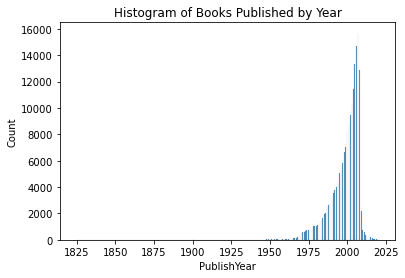

In [84]:
#visualize the year most books are from
sns.histplot(df["PublishYear"], kde = False).set_title("Histogram of Books Published by Year")
plt.show()

In [95]:
print(df['CountsOfReview'].mean())
print(df['CountsOfReview'].min())
print(df['CountsOfReview'].max())
#sns.histplot(df["CountsOfReview"], kde = False).set_title("Histogram of Counts of Review")
#plt.show()

77.96132422603058
0
154447


<AxesSubplot:xlabel='countgroup', ylabel='Rating'>

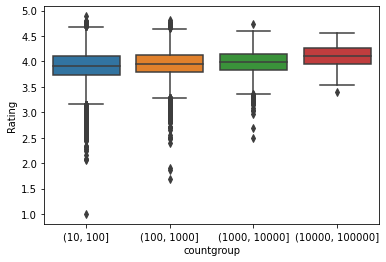

In [97]:
# Create CountsOfReview strata based on cut points
df["countgroup"] = pd.cut(df.CountsOfReview, [10, 100, 1000, 10000, 100000]) 
#boxplot of Counts of Reviews and Ratings
sns.boxplot(x="countgroup", y="Rating", data=df)

#the plot indicates that books with more reviews also tend to have higher ratings with a smaller span of ratings
#books with less ratings have a much greater variation in the mean rating and also slightly lower ratings overall.

In [16]:
#create list of columns with relevant features
columns =['book_title', 'book_author', 'publisher']
#add new column with merged features
df['combined'] = df[columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187249 entries, 0 to 187248
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         187249 non-null  int64  
 1   book_title      187249 non-null  object 
 2   publisher       184576 non-null  object 
 3   CountsOfReview  187249 non-null  int64  
 4   PublishYear     187249 non-null  int64  
 5   Language        187249 non-null  object 
 6   book_author     187249 non-null  object 
 7   Rating          187249 non-null  float64
 8   ISBN            185616 non-null  object 
 9   img_l           187249 non-null  object 
 10  combined        187249 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 15.7+ MB


In [17]:
#convert text of new column to a matrix of word counts
cm = CountVectorizer().fit_transform(df['combined'])
#print(cm)
cm

<187249x91711 sparse matrix of type '<class 'numpy.int64'>'
	with 1864182 stored elements in Compressed Sparse Row format>

In [ ]:
#get cosine similarity matrix from the count matrix
#cs = cosine_similarity(cm)
#error message: "MemoryError: Unable to allocate 90.7 GiB for an array with shape (12176597487,) and data type int64"

In [18]:
#split df in rarerely reviewed books and more commonly reviewed books
rare_books = df[df['CountsOfReview'] <= 100]
common_books = df[df['CountsOfReview'] > 100]
rare_books = rare_books.reset_index(drop=True)
common_books = common_books.reset_index(drop=True)
common_books
#rare_books

,user_id,book_title,publisher,CountsOfReview,PublishYear,Language,book_author,Rating,ISBN,img_l,combined
0,1,Harry Potter and the Half-Blood Prince (Harry ...,Scholastic Inc.,28062,2006,eng,J.K. Rowling,4.57,NaN,https://lightning.od-cdn.com/static/img/no-cov...,Harry Potter and the Half-Blood Prince (Harry ...
1,2,Harry Potter and the Order of the Phoenix (Har...,Scholastic Inc.,29770,2004,eng,J.K. Rowling,4.50,0439358078,http://images.amazon.com/images/P/0439358078.0...,Harry Potter and the Order of the Phoenix (Har...
2,3,Harry Potter and the Sorcerer's Stone (Harry P...,Scholastic Inc,75911,2003,eng,J.K. Rowling,4.47,NaN,https://lightning.od-cdn.com/static/img/no-cov...,Harry Potter and the Sorcerer's Stone (Harry P...
3,4,Harry Potter and the Chamber of Secrets (Harry...,Scholastic,244,2003,eng,J.K. Rowling,4.42,0439554896,http://images.amazon.com/images/P/0439554896.0...,Harry Potter and the Chamber of Secrets (Harry...
4,5,Harry Potter and the Prisoner of Azkaban (Harr...,Scholastic Inc.,37093,2004,eng,J.K. Rowling,4.57,043965548X,http://images.amazon.com/images/P/043965548X.0...,Harry Potter and the Prisoner of Azkaban (Harr...
...,...,...,...,...,...,...,...,...,...,...,...
17089,994740,"Trent's Last Case (Philip Trent, #1)",House of Stratus,145,2001,eng,E.C. Bentley,3.78,0755103270,http://images.amazon.com/images/P/0755103270.0...,"Trent's Last Case (Philip Trent, #1) E.C. Bent..."
17090,994937,Beast In View,Carrol & Graf Publishers,164,1999,eng,Margaret Millar,3.77,0786706678,https://lightning.od-cdn.com/static/img/no-cov...,Beast In View Margaret Millar Carrol & Graf Pu...
17091,998880,Angels & Demons,Washington Square Press,183,2006,eng,Dan Brown,3.90,074349346X,http://images.amazon.com/images/P/074349346X.0...,Angels & Demons Dan Brown Washington Square Press
17092,999346,"Naughts & Crosses (Noughts & Crosses, #1)",Simon Schuster Books for Young Readers,200,2005,eng,Malorie Blackman,4.23,1416900160,https://lightning.od-cdn.com/static/img/no-cov...,"Naughts & Crosses (Noughts & Crosses, #1) Malo..."


In [19]:
print(common_books['book_title'][1])

Harry Potter and the Order of the Phoenix (Harry Potter, #5)


In [69]:
def content_based_recommender(inp):
    
    book_title = str(inp)
    if book_title in df['book_title'].values:
        rare_books = df[df['CountsOfReview'] <= 100]
        common_books = df[df['CountsOfReview'] > 100]
        
        if book_title in rare_books:
            
            random = pd.Series(common_books['book_title'].unique()).sample(2).values
            print('There are no recommendations for this book')
            print('Try: \n')
            print('{}'.format(random[0]),'\n')
            print('{}'.format(random[1]),'\n')
        
        else:
            common_books['index'] = [i for i in range(common_books.shape[0])]
            #target_cols = ['book_title','book_author','publisher']
            #common_books['combined'] = [' '.join(common_books[target_cols].iloc[i,].values) for i in range(common_books[target_cols].shape[0])]
            cv = CountVectorizer()
            count_matrix = cv.fit_transform(common_books['combined'])
            cosine_sim = cosine_similarity(count_matrix)
            index = common_books[common_books['book_title'] == book_title]['index'].values[0]
            sim_books = list(enumerate(cosine_sim[index]))
            sorted_sim_books = sorted(sim_books,key=lambda x:x[1],
                                      reverse=True)[1:6]
            
            books = []
            for i in range(len(sorted_sim_books)):
                books.append(common_books[common_books['index'] == sorted_sim_books[i][0]]['book_title'].item())
                        
            fig, axs = plt.subplots(1, 5,figsize=(18,5))
            fig.suptitle('You may also like these books', size = 22)
                               
            for i in range(len(books)):
        
                url = common_books.loc[common_books['book_title'] == books[i],'img_l'][:1].values[0]
                im = Image.open(requests.get(url, stream=True).raw)
                axs[i].imshow(im)
                axs[i].axis("off")
                #axs[i].set_title('Rating: {}'.format(round(df[df['book_title'] == books[i]]['Rating'].mean(), 1)),
                #             y=-0.18,
                #                 color="blue",
                #                 fontsize=14)
                #I first displayed the rating, but since often times book covers are missing, I decided to display title for orientation insead
                # didn't manage to display both, it always turned out either or
                axs[i].set_title(common_books[common_books['index'] == sorted_sim_books[i][0]]['book_title'].values[0], y=-0.18, color="blue", fontsize=12)
                
                fig.show()
                
            
             
                            
    else:
        
        print('Cant find book in dataset, please check spelling')

Please enter the title of a book you like: 
Of Mice and Men


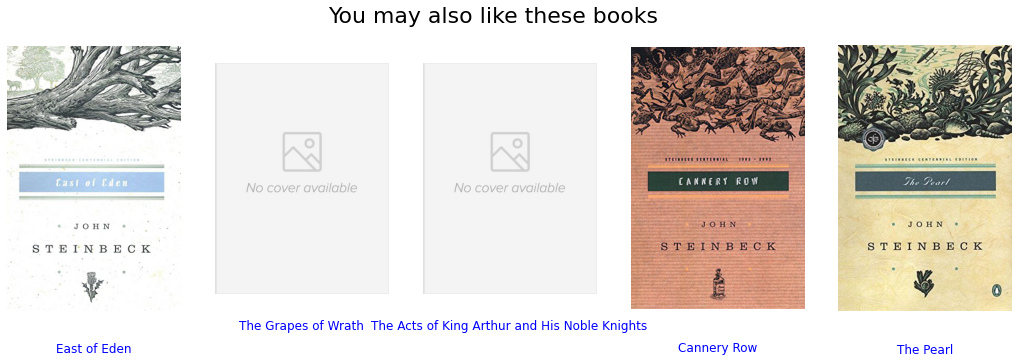

In [76]:
inp = input('Please enter the title of a book you like: \n') 
content_based_recommender(inp)

In [ ]:
#because there are some books without a cover, I also built a recommender that returns the book title and author in writing

In [71]:
def recommender_withoutpictures(inp):
    
    book_title = str(inp)
    if book_title in df['book_title'].values:
        rare_books = df[df['CountsOfReview'] <= 100]
        common_books = df[df['CountsOfReview'] > 100]
        
        if book_title in rare_books:
            
            random = pd.Series(common_books['book_title'].unique()).sample(2).values
            print('There are no recommendations for this book')
            print('Try: \n')
            print('{}'.format(random[0]),'\n')
            print('{}'.format(random[1]),'\n')
        
        else:
            
            common_books['index'] = [i for i in range(common_books.shape[0])]
            cv = CountVectorizer()
            count_matrix = cv.fit_transform(common_books['combined'])
            cosine_sim = cosine_similarity(count_matrix)
            index = common_books[common_books['book_title'] == book_title]['index'].values[0]
            sim_books = list(enumerate(cosine_sim[index]))
            sorted_sim_books = sorted(sim_books,key=lambda x:x[1],
                                      reverse=True)[1:6]
            
            j = 0
            print('\nYou may also like these books:\n')
            for i in range(len(sorted_sim_books)):
                #j.append(common_books[common_books['index'] == sorted_sim_books[i][0]]['book_title'].item())
                title = common_books[common_books['index'] == sorted_sim_books[i][0]]['book_title'].values[0]
                author = common_books[common_books['index'] == sorted_sim_books[i][0]]['book_author'].values[0]
                print(j+1, title, 'by', author)
                j = j+1
                if j >= 5:
                    break
                           
                
    else:
        
        print('Cant find book in dataset, please check spelling')
            
            
            
            

In [75]:
inp = input('Please enter the title of a book you like: \n')
recommender_withoutpictures(inp)

Please enter the title of a book you like: 
Of Mice and Men

You may also like these books:

1 East of Eden by John Steinbeck
2 The Grapes of Wrath by John Steinbeck
3 The Acts of King Arthur and His Noble Knights by John Steinbeck
4 Cannery Row by John Steinbeck
5 The Pearl by John Steinbeck


In [ ]:
# with more time I would have liked to:
# - find a way to display more lines underneth the book image (e.g. title, author and rating)
# - apply casefold so that caps or no caps doesn't matter (ideally, it would even be more of a key word search within the book titles)
# - add other possible features such as recommending also by category (Fiction, NonFiction, Science, etc), page length (long/short reads), publishing year (old/new titles)
# - add combined features such as the item based recommender in combination with a sort by rating or number of reviews etc.